# **Chapter 8**
## *Outlier Detection Using Statistical Methods*, 

This chapter covers statistical methods for outlier and anomaly detection. These practical yet straightforward techniques are easy to interpret and implement. The chapter uses data from the **Numenta Anomaly Benchmark (NAB)** to evaluate different anomaly detection algorithms.

The recipes that you will encounter in this chapter are as follows:  
* Resampling time series data
* Detecting outliers using visualizations
* Detecting outliers using the Tukey method
* Detecting outliers using a z-score
* Detecting outliers using a modified z-score

# -- START --

* If you have the libraries installed check the versions 
* If the libraries are missing or you have an older version then either install or update the library

# Technical Requirements 
* Preparing for the recipes of this chapter

In [1]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.8.1
pandas -> 2.1.3   
scipy -> 1.11.3
statsmodels -> 0.14.0



In [2]:
# Pip install example
# !pip install matplotlib==3.5.0 pandas==1.3.4 scipy==1.7.3 statsmodels==0.11.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = 16, 3

### Create DataFrames 

In [4]:
file = Path("../../datasets/Ch8/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

nyc_taxi.index.freq = '30T'

In [87]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'ro', markersize=20)
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

The New York Taxi dataset captures the number of NYC taxi passengers at a specific timestamp. The data contains known anomalies that are provided to evaluate the performance of our outlier detectors. The dataset contains 10,320 records between July 1, 2014, to May 31, 2015. The observations are captured in a 30-minute interval, which translates to freq = '30T'.

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30T')

In [7]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

If you investigate these dates to gain more insight into their significance, you will find similar information to the following summary:
* Saturday, November 1, 2014, was before the New York Marathon, and the official marathon event was on Sunday, November 2, 2014.
* Thursday, November 27, 2014, was Thanksgiving Day.
* Thursday, December 25, 2014, was Christmas Day.
* Thursday, January 1, 2015, was New Year's Day.
* Tuesday, January 27, 2015, was the North American Blizzard where all vehicles were ordered off the street from January 26 to January 27, 2015.

<Axes: title={'center': 'NYC Taxi'}, xlabel='timestamp'>

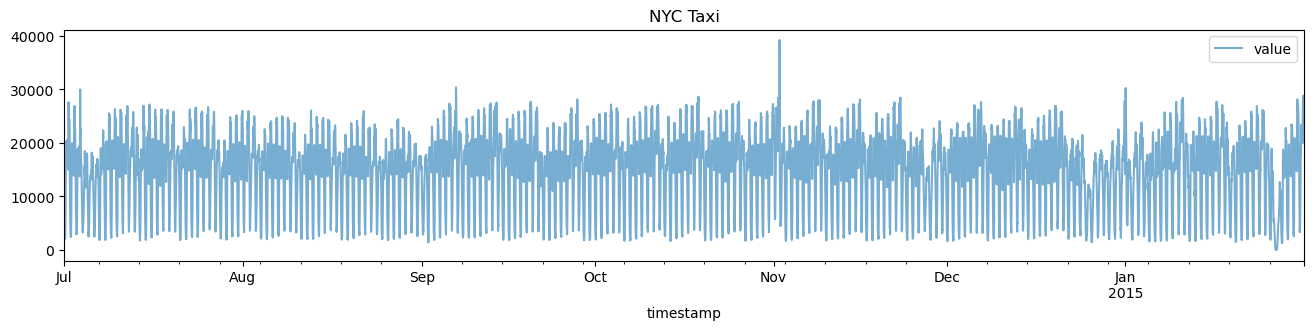

In [72]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

In [9]:
nyc_taxi.index.freq = '30T'

In [10]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30T')

In [11]:
tx = nyc_taxi.resample('D').mean()

In [12]:
known_outliers = tx.loc[nyc_dates]

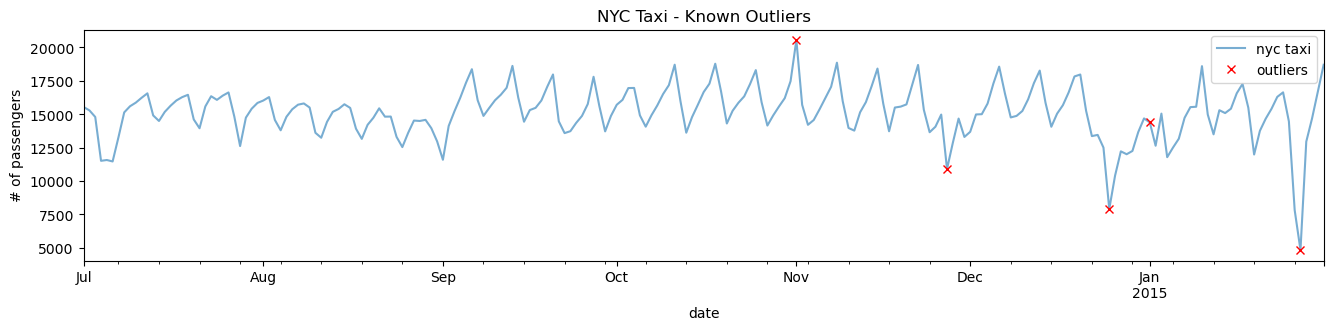

In [88]:
plot_outliers(known_outliers, tx, 'Known Outliers')

# Recipe 1. Resampling Time Series Data
* Learn about upsampling
* Learn about downsampling

In [14]:
nyc_taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [15]:
df_downsampled = nyc_taxi.resample('D').mean()
df_downsampled.head()

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


In [16]:
df_downsampled.index[0]

Timestamp('2014-07-01 00:00:00')

In [17]:
df_downsampled.index.freq

<Day>

In [18]:
df_downsampled.shape

(215, 1)

In [19]:
df_downsampled = nyc_taxi.resample('3D').sum()
df_downsampled.head()

,value
timestamp,
2014-07-01,2189749
2014-07-04,1658320
2014-07-07,2111672
2014-07-10,2335629
2014-07-13,2139711


In [20]:
df_downsampled.shape

(72, 1)

In [21]:
df_downsampled.index.freq

<3 * Days>

In [22]:
df_downsampled = nyc_taxi.resample('3B', origin='end_day').sum()
df_downsampled.head(5)

,value
timestamp,
2014-07-01,745967
2014-07-04,1996347
2014-07-09,3217427
2014-07-14,3747009
2014-07-17,2248113


In [23]:
nyc_taxi.resample('15T').mean().head()

,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [24]:
nyc_taxi.resample('15T').fillna('ffill').head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


In [25]:
nyc_taxi.resample('15T').ffill().head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


## There is more

In [26]:
nyc_taxi.resample('MS').agg(['mean', 'min', 
                            'max', 'median', 'sum'])

value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889

# Recipe 2. Detecting Outliers using Visualization

* You will be using the nyc_taxi DataFrame that you loaded earlier in the Technical requirements section. 
* You will be using seaborn version 0.11.2, which is the latest version as of this writing.

    * To install seaborn using `pip`, use the following: 
    
    
    ```
    pip install seaborn
    ```
    
    * To install seaborn using `conda`, use the following:  
    
    
    ```
    conda install seaborn
    ```

In [27]:
import seaborn as sns
sns.__version__

'0.13.0'

In [28]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


## Histogram

<Axes: ylabel='Count'>

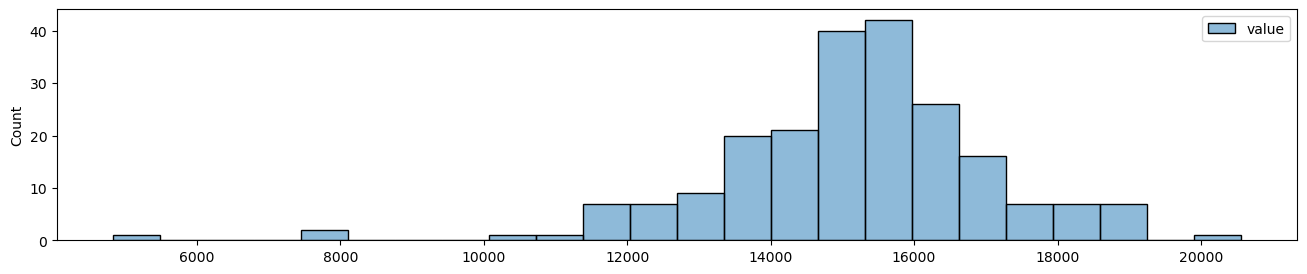

In [29]:
sns.histplot(tx)

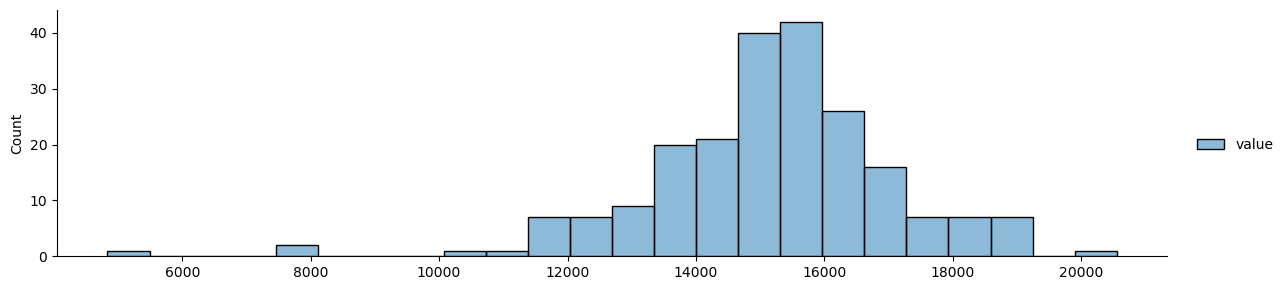

In [30]:
sns.displot(tx, kind='hist', height=3, aspect=4)

## Box Plot

<Axes: ylabel='value'>

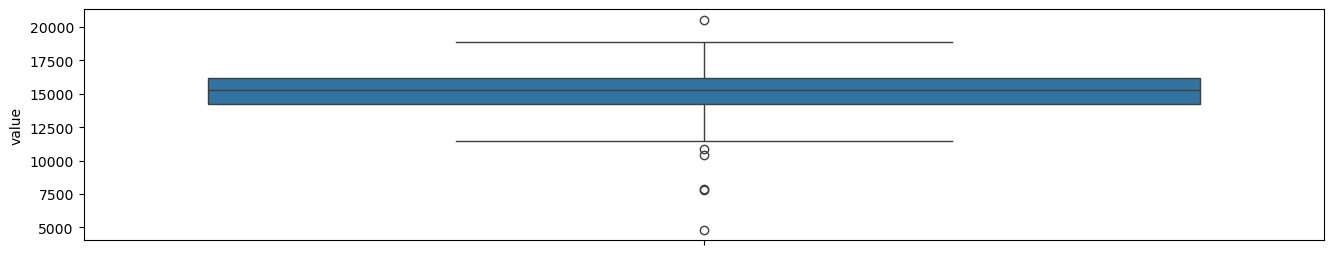

In [31]:
sns.boxplot(tx['value'], whis=1.5)

In [32]:
tx.describe()

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
25%,14205.197917
50%,15299.937500
75%,16209.427083
max,20553.500000


## Boxen Plot (Letter Value)

<Axes: ylabel='value'>

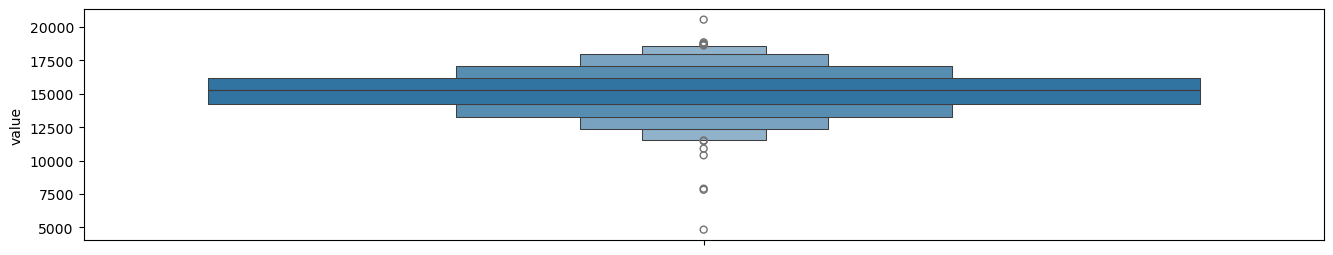

In [33]:
sns.boxenplot(tx['value'])

<Axes: ylabel='value'>

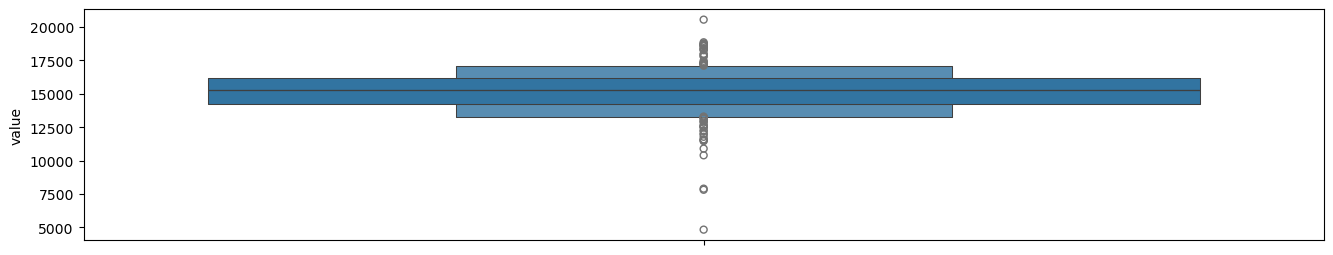

In [34]:
# changing depth with numeric value
sns.boxenplot(tx['value'], k_depth=2) 

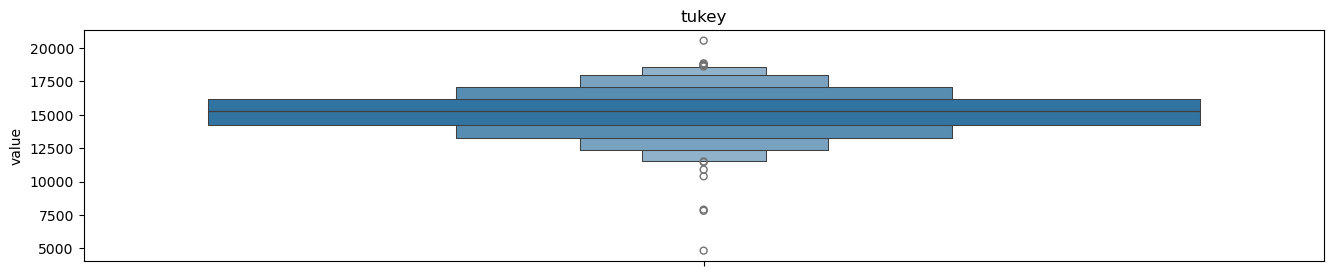

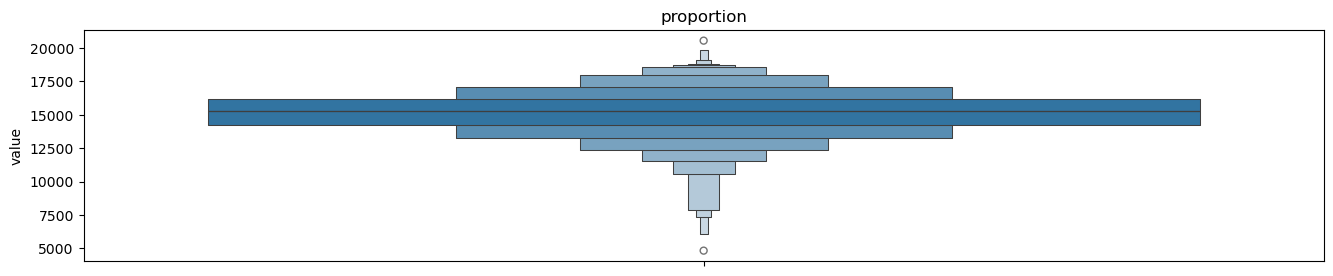

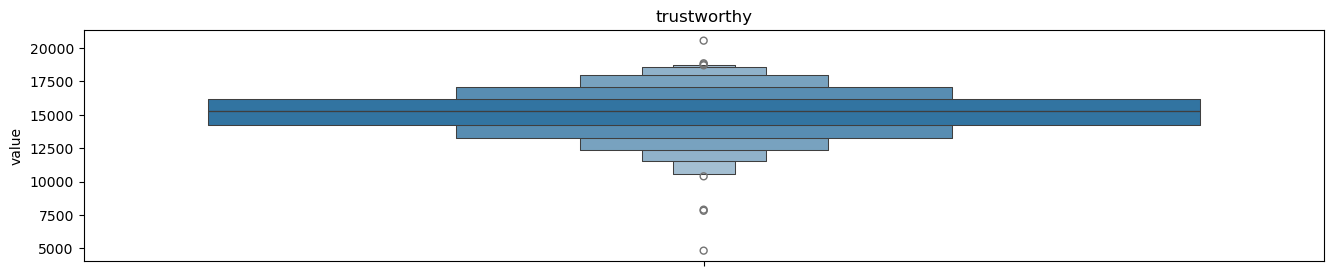

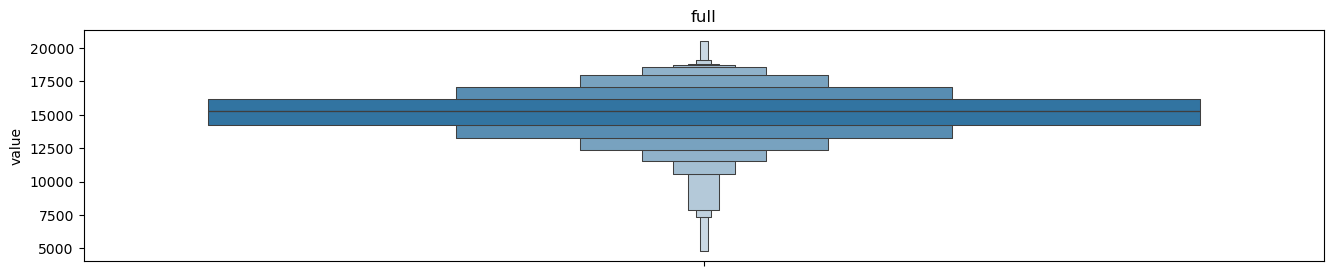

In [35]:
# exploring different methods 
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(tx['value'], k_depth=k)
    plt.title(k)
    plt.show()

## Violin Plot

<Axes: ylabel='value'>

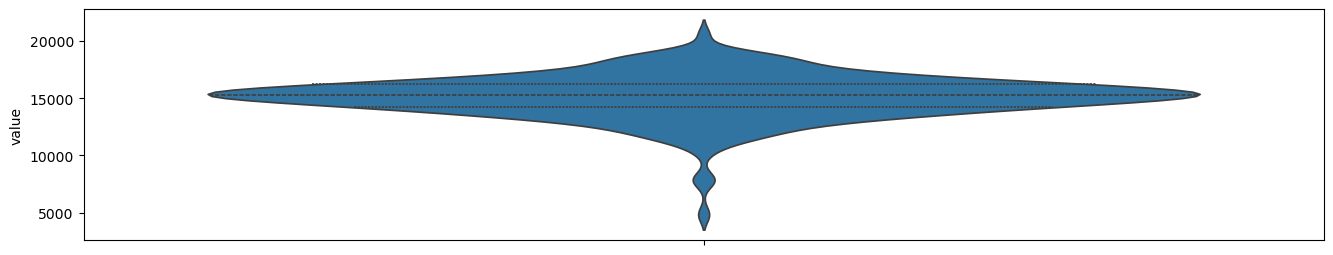

In [36]:
sns.violinplot(tx['value'], inner='quartile')

## There is more
### Lag Plot

In [37]:
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

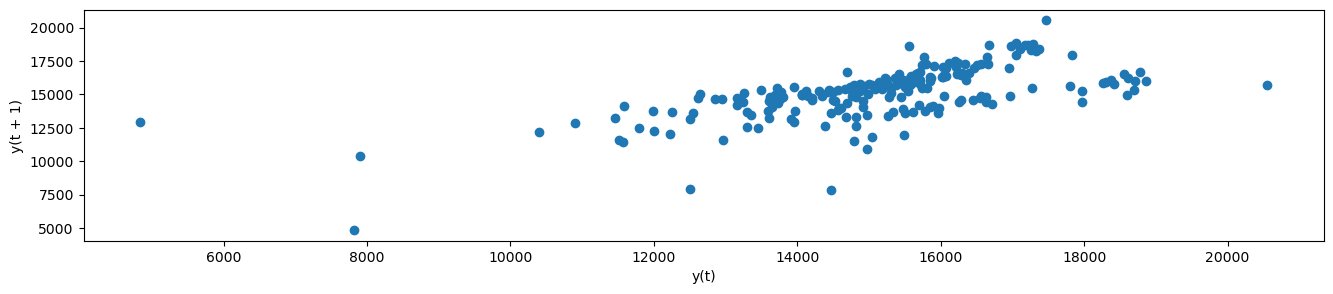

In [38]:
lag_plot(tx, lag=1)

Creating a Lag Plot using `seaborn.scatterplot`

<Axes: >

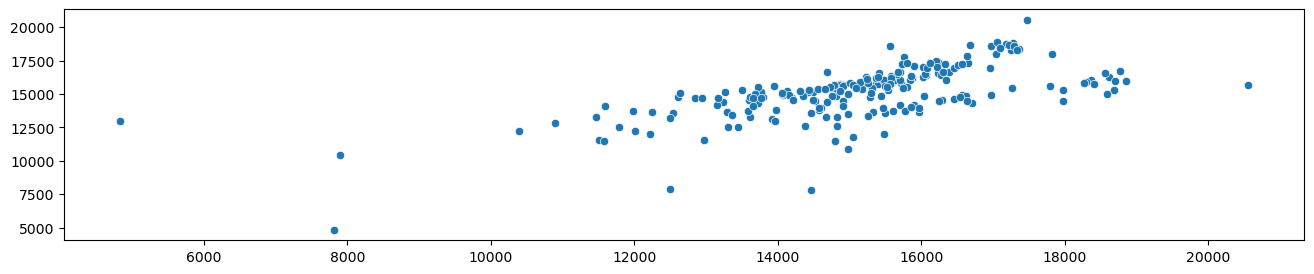

In [39]:
y = tx[1:].values.reshape(-1)
x = tx[:-1].values.reshape(-1)
sns.scatterplot(x=x, y=y)

# Recipe 3. Detecting Outliers using Tukey’s Method

Define the `iqr_outliers` functions

In [40]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


In [41]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

In [42]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [43]:
outliers = iqr_outliers(tx)
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


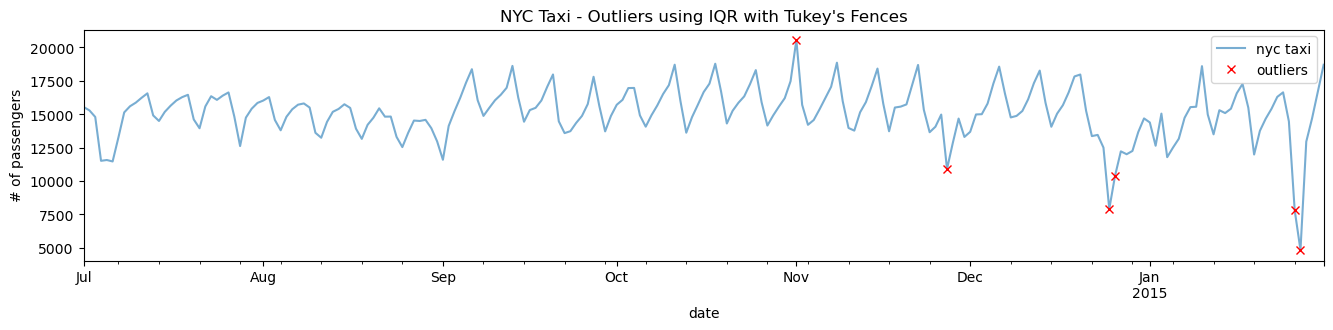

In [44]:
plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences")

In [45]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


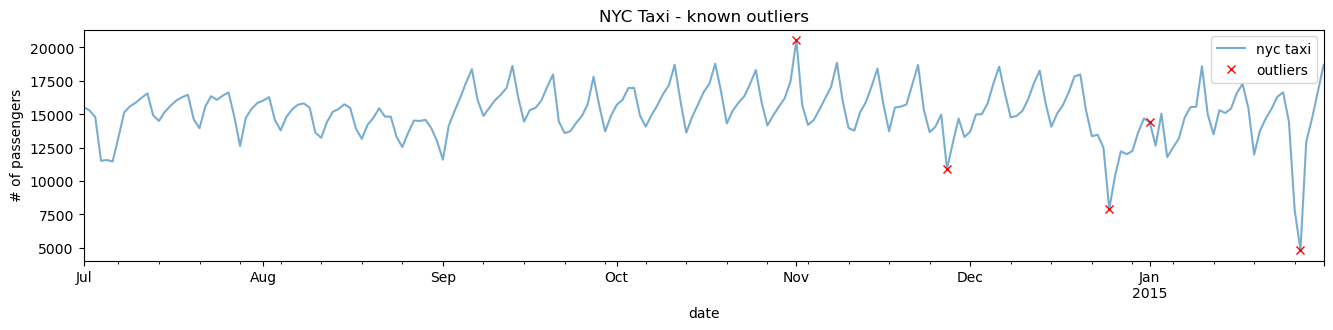

In [46]:
plot_outliers(known_outliers, tx, "known outliers")

## There is more

In [47]:
def iqr_outliers(data, p):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (p * IQR)
    upper_fence = q3 + (p * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [48]:
for p in [1.3, 1.5, 2.0, 2.5,  3.0]:
    print(f'with p={p}')
    print(iqr_outliers(tx, p))
    print('-'*15)

with p=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
---------------
with p=3.0
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  78

# Recipe 4. Detecting Outliers with Z-score
* What is Z-Score
* Assumptions for Z-Score
* How it is used for Outlier/Anomaly Detection

**Z-Scores**

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [49]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    
    return outliers['value'], data

In [50]:
threshold = 2.5
outliers, transformed = zscore(tx, threshold)

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'zscore'}>]], dtype=object)

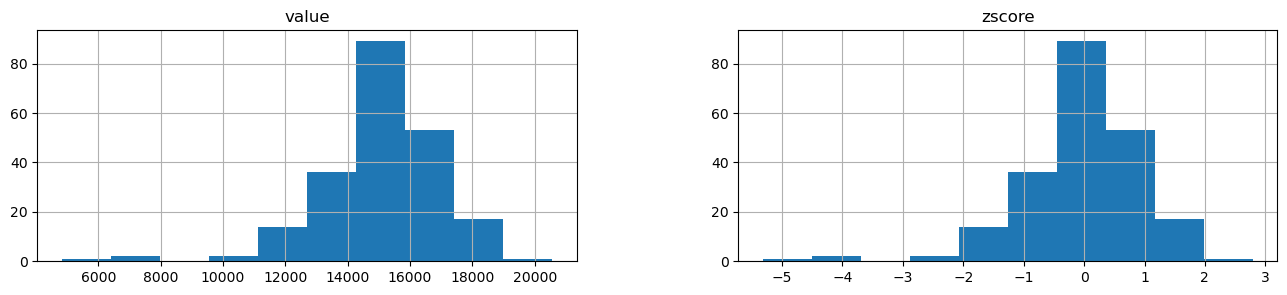

In [51]:
transformed.hist()

In [52]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [53]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


In [54]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

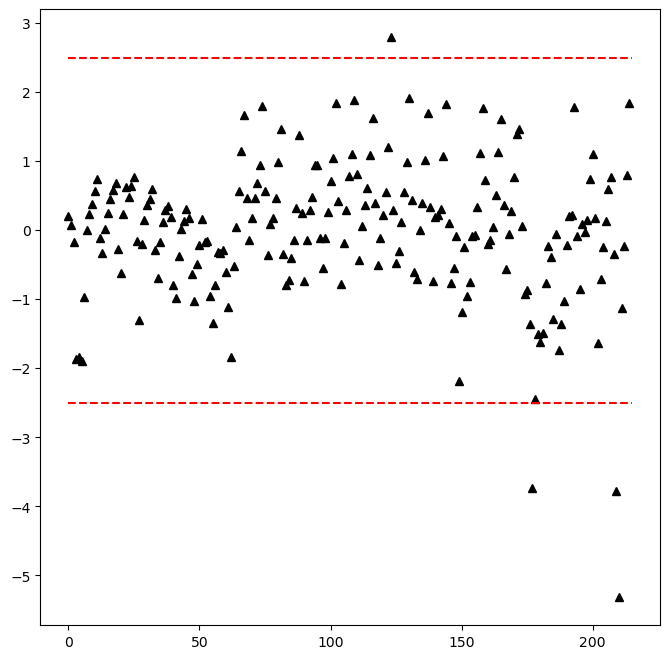

In [55]:
data = transformed['zscore'].values
plot_zscore(data, d=2.5)

In [56]:
outliers

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64

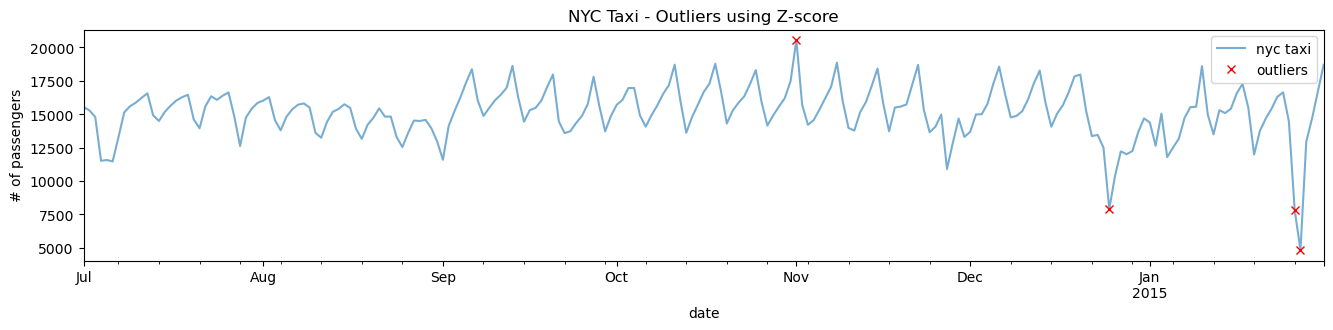

In [57]:
plot_outliers(outliers, tx, 'Outliers using Z-score')

### There is more

In [58]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [59]:
test_normal(tx)

Reject null hypothesis. Data is not normal


# Recipe 5. Modified Z-Score
* Understand the difference between Z-Score and Modified Z-Score
* When to use Modified Z-Score (and the assumptions behind Z-score)
* Scipy's Percent Point Function (PPF)

In [60]:
import scipy.stats as stats
stats.norm.ppf(0.75)

0.6744897501960817

In [61]:
def modified_zscore(df, degree=3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]
    
    return outliers['value'], data

In [62]:
threshold =  3
outliers, transformed = modified_zscore(tx, threshold)

In [63]:
outliers.shape

(6,)

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'm_zscore'}>]], dtype=object)

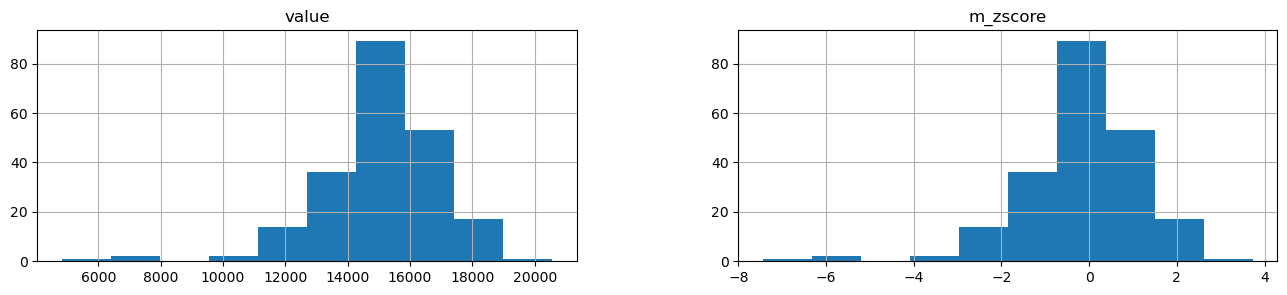

In [64]:
transformed.hist()

In [65]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


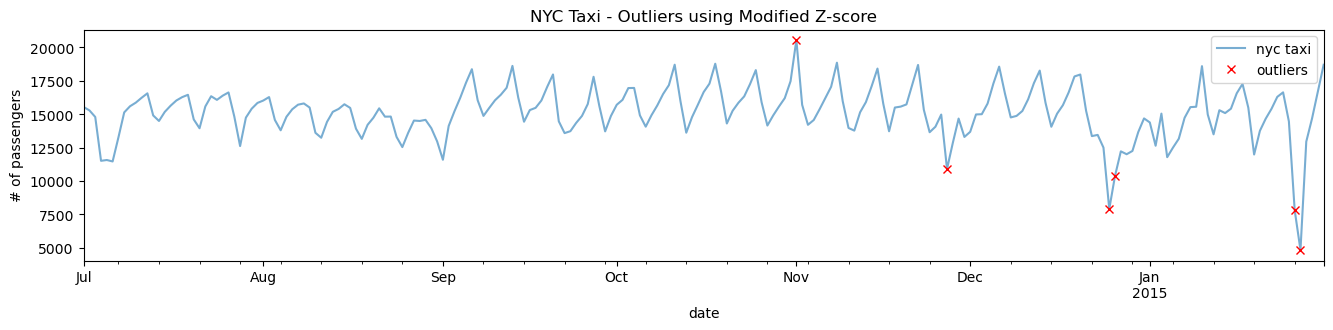

In [66]:
plot_outliers(outliers, tx, 'Outliers using Modified Z-score')

In [67]:
def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

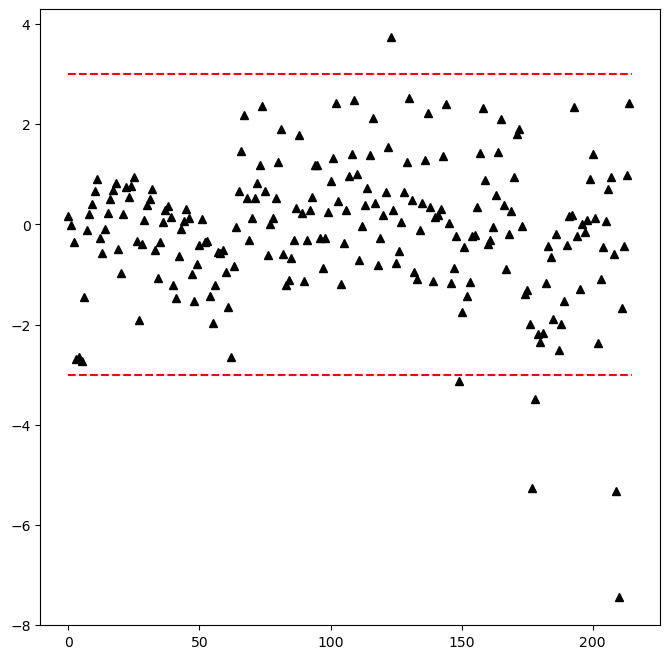

In [68]:
data = transformed['m_zscore'].values
plot_m_zscore(data, d=3)

## There is more

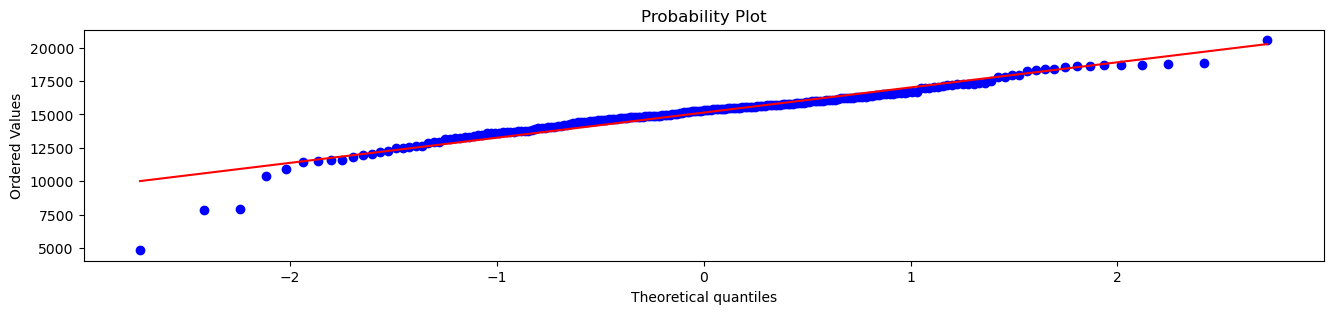

In [69]:
import scipy
import matplotlib.pyplot as plt
res = scipy.stats.probplot(tx.values.reshape(-1), plot=plt)

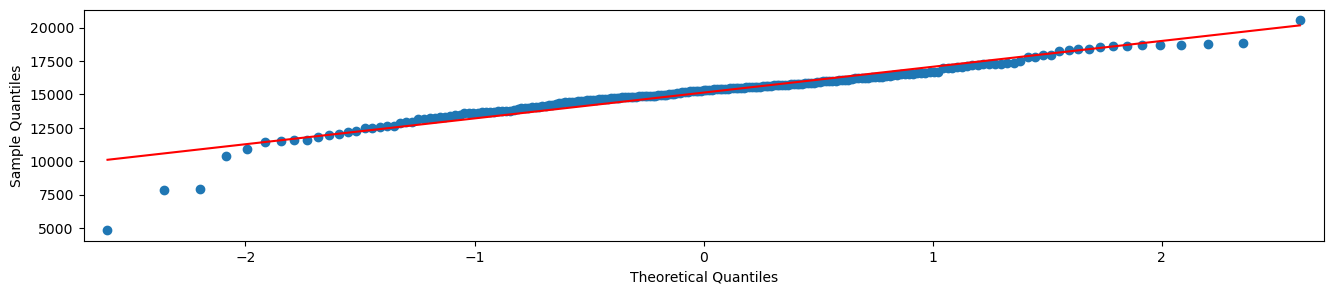

In [70]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx.values.reshape(-1), line='s');